In [2]:
import torch
assert torch.cuda.is_available(), "Cuda isn't available"


In [3]:
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import time

from data_loader import CTDataset
from model_vqvae2 import VQVAE

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
EASY_MODE = True

In [6]:
#################################################
# PROVIDED: PSNR evaluation method
#################################################
def psnr(im, ref, margin=2):
    """
    Args:
    im (torch.Tensor): Image to be evaluated. 
    Has shape `(num_channels, height, width)`.
    ref (torch.Tensor): reference image. 
    Has shape `(num_channels, height, width)`. 

    Returns:
    psnr (int): psnr value of the images.
    """
    # assume images are tensors float 0-1.
    # im, ref = (im*255).round(), (ref*255).round()
    # rgb2gray = torch.Tensor([65.481, 128.553, 24.966]).to(im.device)[None, :, None, None]
    gray_im = im #torch.sum(im * rgb2gray, dim=1) + 16
    gray_ref = ref # torch.sum(ref * rgb2gray, dim=1) + 16
    clipped_im = torch.clamp(gray_im, 0, 255).squeeze()
    clipped_ref = torch.clamp(gray_ref, 0, 255).squeeze()
    shaved_im = clipped_im#[margin:-margin, margin:-margin]
    shaved_ref = clipped_ref#[margin:-margin, margin:-margin]    
    return 20 * torch.log10(torch.tensor(255.)) -10.0 * ((shaved_im) - (shaved_ref)).pow(2.0).mean().log10()

In [7]:
def train_epoch(model, optimizer, train_criterion, data_loader, loss_history, device):
    total_samples = len(data_loader.dataset)
    model.train()
    total_loss = 0
    for i, (scan, mask, masked) in enumerate(data_loader):
        target = scan
        mask = mask.to(device)
        masked = masked.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        masked = masked[None, :]
        masked = masked.transpose(0, 1)
        output, diff = model(masked)
        if EASY_MODE:
            # TODO remove clamp?
            output -= output.min(1, keepdim=True)[0] - 0.01
            output /= output.max(1, keepdim=True)[0] + 0.01
        output = output.squeeze()
        # TODO consider remove this squeeze
        target = target.squeeze()
        
        predicted_mask = torch.masked_select(output, mask)
        target_mask = torch.masked_select(target, mask)
        loss = train_criterion(predicted_mask, target_mask)
        # TODO reset to mask loss?
        # loss = train_criterion(output, target)
        
        # print(f"loss: {loss.cpu()}")
        # loss.sum()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(scan)) + '/' + '{:5}'.format(total_samples) +
                ' (' + '{:3.0f}'.format(100 * i / total_samples) + '%)]  Loss: ' +
                '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())
    
    return total_loss/total_samples

In [8]:
def evaluate(model, data_loader, criterion, loss_history, device):
    model.eval()
  
    total_psnr = 0
    total_loss = 0
    total_samples = len(data_loader.dataset)

    with torch.no_grad():
        for i, (scan, mask, masked) in enumerate(data_loader):
            target = scan
            mask = mask.to(device)
            masked = masked.to(device)
            target = target.to(device)

            masked = masked[None, :]
            masked = masked.transpose(0, 1)
            output, diff = model(masked)
            if EASY_MODE:
                # TODO remove\ clamp?
                output -= output.min(1, keepdim=True)[0] - 0.01
                output /= output.max(1, keepdim=True)[0] + 0.01
                # output = torch.clamp(masked, 0.01, 0.99)
            output = output.squeeze()
            # TODO consider remove this squeeze
            target = target.squeeze()
            
            
            predicted_mask = torch.masked_select(output, mask)
            target_mask = torch.masked_select(target, mask)
            loss = criterion(predicted_mask, target_mask)
            # TODO return full loss
            # loss = criterion(output, target)
            

            cur_psnr = psnr(predicted_mask, target_mask)
            
            total_loss += loss.item()
            total_psnr += cur_psnr

    avg_loss = total_loss / total_samples
    avg_psnr = total_psnr / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
            '  Average test PSNR:' + '{}'.format(avg_psnr)+'\n')
    return avg_loss, avg_psnr


In [9]:
def train(lr=1e-2, n_epochs=10, limit_dataset=None, batch_size_train=10, batch_size_test=10, lr_decay=1, lr_step=10):
    device = torch.device('cuda')
    start_time = time.time()
    
    tb_writer = SummaryWriter()

    if EASY_MODE:
        mask_dims = (16, 16)
    else:
        mask_dims = (64, 64)
    # Load data
    DATASET_DIR = "COVID-CTset"
    train_set = CTDataset(DATASET_DIR, limit_dataset=limit_dataset, num_masked_slices=2, padding_slices=3, mask_dims=mask_dims)
    # train_set = CTDataset(DATASET_DIR, limit_dataset=limit_dataset, num_masked_slices=2, padding_slices=3)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=2)

    test_set = train_set
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False, num_workers=2)

    # Initialize model
    model = VQVAE(in_channel=1).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=lr_decay)
    
    if EASY_MODE:
        criterion = torch.nn.BCELoss()
    else:
        criterion = torch.nn.MSELoss()
        # criterion = torch.nn.L1Loss()
            
    
    
    # Train model
    train_loss_history, test_loss_history = [], []
    for epoch in range(1, n_epochs + 1):
        curr_start_time = time.time()
        train_loss = train_epoch(model, optimizer, criterion, train_loader, train_loss_history, device)
        tb_writer.add_scalar("Loss/train", train_loss, epoch)
        tb_writer.add_scalar("lr", scheduler.optimizer.param_groups[0]['lr'], epoch)
        
        scheduler.step()
        if epoch % 10 == 0:
            eval_loss, eval_psnr = evaluate(model, test_loader, criterion, test_loss_history, device)
            print('Epoch:', epoch)
            print(f'Epoch {epoch} execution time:', '{:5.2f}'.format((time.time() - curr_start_time) / 60), 'minutes\n')
            tb_writer.add_scalar("Loss/val", eval_loss, epoch)
            tb_writer.add_scalar("PSNR/val", eval_psnr, epoch)


    print('Execution time:', '{:5.2f}'.format((time.time() - start_time) / 60), 'minutes')
    return model



In [17]:
# model = train(n_epochs=10000, limit_dataset=1, batch_size_train=1, batch_size_test=1, lr=0.01, lr_step=100, lr_decay=0.5)
model = train(n_epochs=200, limit_dataset=1, batch_size_train=1, batch_size_test=1, lr=0.01, lr_step=50, lr_decay=0.1)

/home/labs/testing/class62/CT-Inpainting/model_vqvae2.py:56: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /opt/conda/conda-bld/pytorch_1670525553989/work/torch/csrc/utils/python_arg_parser.cpp:1420.)
  1 - self.decay, embed_onehot.sum(0)


[    0/    1 (  0%)]  Loss: 0.6932
[    0/    1 (  0%)]  Loss: 0.6931
[    0/    1 (  0%)]  Loss: 0.6941
[    0/    1 (  0%)]  Loss: 0.6937
[    0/    1 (  0%)]  Loss: 0.6933
[    0/    1 (  0%)]  Loss: 0.6940
[    0/    1 (  0%)]  Loss: 0.6932
[    0/    1 (  0%)]  Loss: 0.6939
[    0/    1 (  0%)]  Loss: 0.6938
[    0/    1 (  0%)]  Loss: 0.6933

Average test loss: 0.6940  Average test PSNR:0.017047882080078125

Epoch: 10
Epoch 10 execution time:  0.05 minutes

[    0/    1 (  0%)]  Loss: 0.6937
[    0/    1 (  0%)]  Loss: 0.6938
[    0/    1 (  0%)]  Loss: 0.6935
[    0/    1 (  0%)]  Loss: 0.6938
[    0/    1 (  0%)]  Loss: 0.6940
[    0/    1 (  0%)]  Loss: 0.6939
[    0/    1 (  0%)]  Loss: 0.6939
[    0/    1 (  0%)]  Loss: 0.6931
[    0/    1 (  0%)]  Loss: 0.6936
[    0/    1 (  0%)]  Loss: 0.6933

Average test loss: 0.6937  Average test PSNR:0.3567314147949219

Epoch: 20
Epoch 20 execution time:  0.02 minutes

[    0/    1 (  0%)]  Loss: 0.6934
[    0/    1 (  0%)]  Loss: 0.6

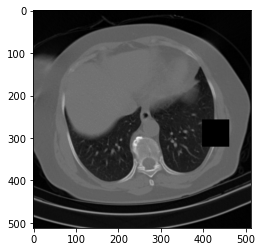

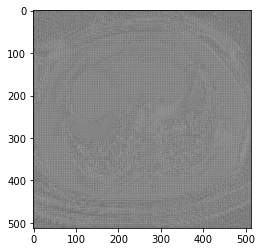

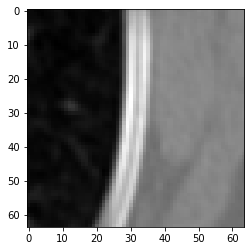

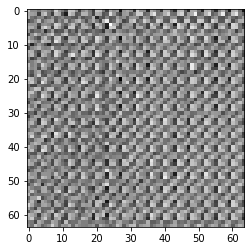

In [17]:
from ct_utils import ctshow

device = torch.device('cuda')
# Load data
DATASET_DIR = "COVID-CTset"
# train_set = CTDataset(DATASET_DIR, limit_dataset=1, num_masked_slices=2, padding_slices=3)
if EASY_MODE:
    mask_dims = (16, 16)
    inpaint_dims = (2, 16, 16)
else:
    mask_dims = (64, 64)
    inpaint_dims = (2, 64, 64)
    
train_set = CTDataset(DATASET_DIR, limit_dataset=1, num_masked_slices=2, padding_slices=3, mask_dims=mask_dims)

data_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2)

# Initialize model
model = VQVAE(in_channel=1).to(device)

with torch.no_grad():
    for i, (scan, mask, masked) in enumerate(data_loader):
        target = scan
        mask = mask.to(device)
        masked = masked.to(device)
        target = target.to(device)

        masked = masked[None, :]
        masked = masked.transpose(0, 1)
        output, diff = model(masked)
        output = output.squeeze()

        predicted_mask = torch.masked_select(output, mask)
        target_mask = torch.masked_select(target, mask)
        predicted_mask = predicted_mask.to(torch.device('cpu')).reshape(*inpaint_dims)
        target_mask = target_mask.to(torch.device('cpu')).reshape(*inpaint_dims)

        masked = masked.squeeze().cpu()
        ctshow(masked[3])
        ctshow(output[3].cpu())
        ctshow(target_mask[0])
        ctshow(predicted_mask[0])
        
        




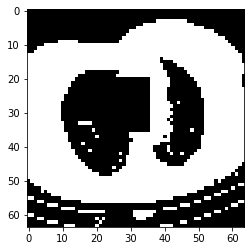

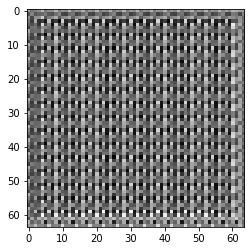

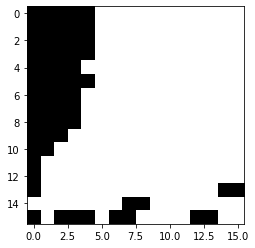

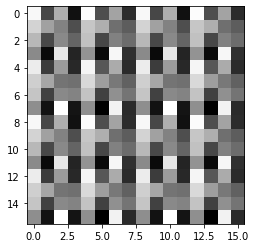

In [15]:
from ct_utils import ctshow

device = torch.device('cuda')
# Load data
DATASET_DIR = "COVID-CTset"
# train_set = CTDataset(DATASET_DIR, limit_dataset=1, num_masked_slices=2, padding_slices=3)
train_set = CTDataset(DATASET_DIR, limit_dataset=1, num_masked_slices=2, padding_slices=3, mask_dims=(16, 16))

data_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=2)

# Initialize model
model = VQVAE(in_channel=1).to(device)

with torch.no_grad():
    for i, (scan, mask, masked) in enumerate(data_loader):
        target = scan
        mask = mask.to(device)
        masked = masked.to(device)
        target = target.to(device)

        masked = masked[None, :]
        masked = masked.transpose(0, 1)
        output, diff = model(masked)
        output = output.squeeze()

        predicted_mask = torch.masked_select(output, mask)
        target_mask = torch.masked_select(target, mask)
        predicted_mask = predicted_mask.to(torch.device('cpu')).reshape(2, 16, 16)
        target_mask = target_mask.to(torch.device('cpu')).reshape(2, 16, 16)

        masked = masked.squeeze().cpu()
        ctshow(masked[3])
        ctshow(output[3].cpu())
        ctshow(target_mask[0])
        ctshow(predicted_mask[0])
        
        




(array([8.863e+03, 4.717e+03, 9.330e+02, 5.109e+03, 1.162e+04, 1.094e+03,
        3.370e+02, 7.000e+01, 1.700e+01, 8.000e+00]),
 array([   0. ,  229.8,  459.6,  689.4,  919.2, 1149. , 1378.8, 1608.6,
        1838.4, 2068.2, 2298. ], dtype=float32),
 <BarContainer object of 10 artists>)

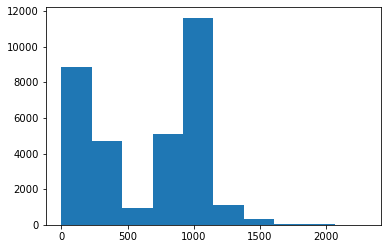

In [17]:
import matplotlib.pyplot as plt
plt.hist(masked.flatten())

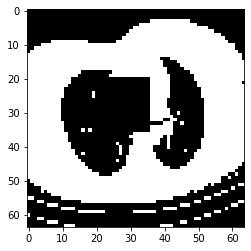

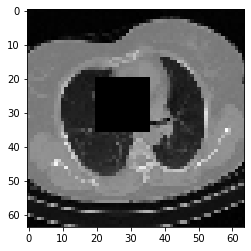

In [26]:
normalized_masked = torch.where(masked < 500, 0, 1)
ctshow(normalized_masked[4])
ctshow(masked[4])

(array([ 5688.,  2368.,  3349.,  1761.,   637.,   382.,   364.,   318.,
         1328., 16573.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.], dtype=float32),
 <BarContainer object of 10 artists>)

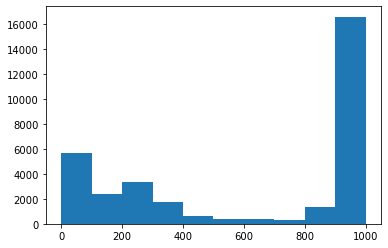

In [25]:
plt.hist(normalized_masked.flatten())